# Computing Eigenvalues

## What's the difficulty?

From Abel's theorem it follows that we cannot generally compute eigenvalues in closed from for matrices with dimension larger than 4. Hence, we need iterative methods to compute eigenvalues. The most fundamental method to compute eigenvalues is the power method.

** Algorithm: Power Method**
    
for $k=1,2,\dots$

$\quad z^{(k)} = Aq^{(k-1)}$

$\quad q^{(k)} = z^{(k)}/\|z^{(k)}\|_2$

$\quad \lambda^{(k)} = \left[q^{(k)}\right]^HAq^{(k)}$

end

Assume that $A$ is diagonalizable. We can write $q^{(0)}=\sum_{j=1}^n\alpha_jx_j$, where the $x_j$ are the eigenvectors of $A$ associated with the eigenvalues $\lambda_j$. We assume the eigenvalues are orderered such that $|\lambda_1|> |\lambda_2|\geq \dots$.

We have

$$
A^{k}q^{(0)} = \sum_{j=1}^n\alpha_j\lambda_j^kx_j = \alpha_1\lambda_1^{k}\left(x_1+\sum_{j=2}^n\frac{\alpha_j}{\alpha_1}\left(\frac{\lambda_j}{\lambda_1}\right)^kx_j\right).
$$

It follows that the error is of the order 
$\mathcal{O}\left(\left|\frac{\lambda_2}{\lambda_1}\right|^k\right)$.

In [1]:
%matplotlib inline

import numpy as np
from numpy.random import rand,randn
from matplotlib import pyplot as plt
from scipy.linalg import eigvals,qr
def power_method(A,q0,k):
    """Evaluates k steps of the power iteration with starting vector q0 for the matrix A. Returns a vector with eigenvalue
       iterates \lambda_j.
    """
    
    lambda_iterates = np.zeros(k,dtype=np.complex128)
    
    q = q0
    
    for i in range(k):
        z = np.dot(A,q)
        q = z/np.linalg.norm(z)
        lambda_iterates[i] = np.dot(np.conjugate(q),np.dot(A,q))
        
    return lambda_iterates


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Text(0,0.5,'\\lambda_j-\\lambda_1')

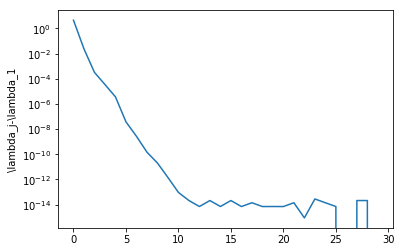

In [6]:
n = 100
k = 30
A = rand(n,n)
q0 = randn(n) + 1j * randn(n)

lambda_iterates = power_method(A,q0,k)
plt.semilogy(np.abs(lambda_iterates-lambda_iterates[-1]))
plt.ylabel('\lambda_j-\lambda_1')

Why the fast convergence?

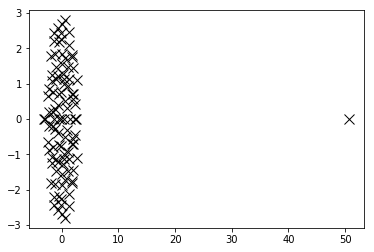

In [7]:
import scipy.linalg

eigvals = scipy.linalg.eigvals(A)
plt.plot(np.real(eigvals), np.imag(eigvals), 'kx',markersize=10)

For matrices consisting of equally distributed random numbers there is one eigenvalues, which is much larger than the others.

## Inverse Iteration

The principle idea of inverse iteration is to transform the spectrum of the matrix $A$ in order to accelerate the eigenvalue convergence.

Let $Ax=\lambda x$. Then we have $(A-\sigma I)^{-1}x=(\lambda-\sigma)^{-1}x$. The biggest eigenvalue is now the one that is closest to $\sigma$, and we can expect that the power method will convergence fast to the eigenvalue close to $\sigma$.

In [8]:
%matplotlib inline

import numpy as np
from numpy.random import rand,randn
from matplotlib import pyplot as plt
from scipy.linalg import eigvals, lu, solve_triangular
def power_method(A,q0,k,sigma):
    """Evaluates k steps of the inverse iteration with starting vector q0 
       for the matrix A and shift sigma. Returns a vector with eigenvalue
       iterates \lambda_j.
    """
    
    lambda_iterates = np.zeros(k,dtype=np.complex128)
    
    q = q0 / np.linalg.norm(q0)
    
    n = A.shape[0]
    
    P,L,U = lu(A-sigma*np.eye(n,n,dtype=A.dtype))
    
    def applyMat(x):
        return solve_triangular(U,solve_triangular(L,np.dot(P,q),lower=True))
    
    for i in range(k):
        z = applyMat(q)
        q = z/np.linalg.norm(z)
        lambda_iterates[i] = np.dot(q.conj(),applyMat(q))
        
    return lambda_iterates

Text(0,0.5,'\\lambda_j-\\lambda_1')

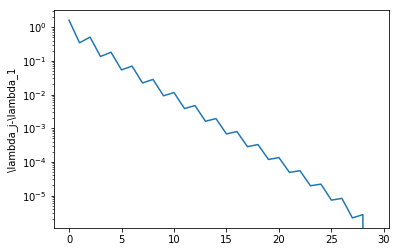

In [11]:
n = 50
k = 30
sigma = .1
A = randn(n,n)
q0 = randn(n) + 1j * randn(n)

lambda_iterates = power_method(A,q0,k,sigma)
plt.semilogy(np.abs(lambda_iterates-lambda_iterates[-1]))
plt.ylabel('\lambda_j-\lambda_1')

In [23]:
print(lambda_iterates)

[ 4.97271163+0.j  5.43614531+0.j  5.43638105+0.j  5.43637965+0.j
  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j
  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j
  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j
  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j
  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j
  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j  5.43637966+0.j
  5.43637966+0.j  5.43637966+0.j]


## Subspace iteration and the QR Algorithm

In many applications we do not just want to compute one eigenvalue but several or even all eigenvalues of a given matrix. In the following we will discuss the basic ideas of the most successful algorithm for computing eigenvalues of general nonsymmetric matrices.

***Algorithm (Subspace Iteration)***

for $k=1,2,\dots$

$\quad Z^{(k)} = AQ^{(k-1)}$

$\quad Q^{(k)}R = Z^{(k)}$ (QR decomposition)

$\quad A^{(k)} = [Q^{(k)}]^HAQ^{(k)}$

end

In [12]:
%matplotlib inline
import numpy as np
from numpy.random import rand, randn
from matplotlib import pyplot as plt
from scipy.linalg import qr
def subspace_iteration(A,k,m):
    """Evaluates k steps of the subspace iteration for the matrix A to find the largest m eigenvalues.
       Return a vector of errors computed via the Frobenius norm.
    """
        
    Z0 = np.random.rand(A.shape[0],m)+1j*np.random.rand(A.shape[0],m)
    Q,R = qr(Z0,mode='economic')
    
    error = np.zeros(k,dtype=np.float64)
    
    for i in range(k):
        Z = np.dot(A,Q)
        Q,R = qr(Z,mode='economic')
        Lambda = np.dot(np.conjugate(Q).T,np.dot(A,Q))
        error[i] = np.linalg.norm(np.tril(Lambda,-1))
        
    return error


Text(0,0.5,'error')

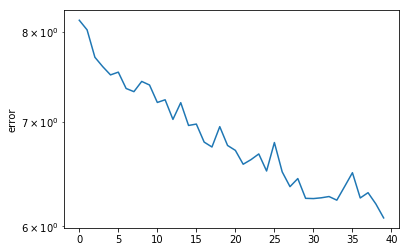

In [16]:
n = 50
k = 40
m = 50
A = rand(n,n)

error = subspace_iteration(A,k,m)
plt.semilogy(error)
plt.ylabel('error')


The iterates $A^{(k)}$ converge against an upper triangular matrix which contains the largest magnitude eigenvalues on its diagonal.

## The QR Algorithm

Instead of applying the subspace iteration to find the $k$ largest eigenvalues we could attempt to apply it to find all $n$ eigenvalues. This is the idea of the QR iteration. It is defined as follows.

**The QR Iteration**

for $k=1,2,\dots$

$A^{(0)} = A$

$A^{(k-1)} = Q^{(k)}R^{(k)}$

$A^{(k)} = R^{(k)}Q^{(k)}$

end

In [17]:
import numpy as np
from numpy.random import rand
from matplotlib import pyplot as plt
from scipy.linalg import qr
def qr_iteration(A,k):
    """Evaluates k steps of the QR iteration for the matrix A to find all eigenvalues.
       Return a vector of errors computed via the Frobenius norm.
    """
            
    error = np.zeros(k,dtype=np.float64)
    
    for i in range(k):
        Q,R = qr(A)
        A = np.dot(R,Q)
        error[i] = np.linalg.norm(np.tril(A,-1))
        
    return error

Text(0,0.5,'error')

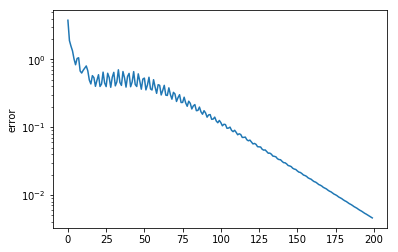

In [18]:
n = 10
k = 200
A = rand(n,n)+1j*rand(n,n)


error = qr_iteration(A,k)
plt.semilogy(error)
plt.ylabel('error')

## Some comments

* Accelerated variants of the QR iteration are the standard algorithm to compute eigenvalues
* All Scipy eigenvalue algorithms for dense nonsymmetric matrices use it.
* In practice the complexity is $O(n^3)$. It takes $O(n^3)$ iteration for an initial so-called
Hessenberg transformation of the matrix. Each eigenvalue is then found in typically two to three iterations to
machine precision.
* Even though QR is iterative due to its fast convergence (when acceleration techniques are used), it is considered like a non-iterative method.

## Symmetric eigenvalue problems

Symmetric eigenvalue problems play a significant role in a range of applications. There structure is significantly simpler than that of general eigenvalue problems, and efficient extremely fast converging methods exist to compute eigenvalues of symm problems.

We consider the Schur decomposition of a hermitian matrix $A\in\mathbb{C}^{n\times n}$ with $A=A^H$.

$$
A = QRQ^H.
$$

We have

$$
A^H = QR^HQ^H.
$$



Since $A=A^H$ it follows that $R=R^H$. Since $R$ is upper triangular this is only possible if $R$ is diagonal. Furthermore, the diagonal must be real. It follows that all eigenvalues are real. This implies that all eigenvectors are also real if $A$ is real. Moreover, we have

$$
A = Q\Lambda Q^H,
$$
where $\Lambda$ is the diagonal matrix containing the eigenvalues. Hence, the Schur vectors are also the eigenvectors, implying that the eigenvectors form an orthonormal basis of $\mathbb{R}^n$.


## Rayleigh Quotients

Let $A\in\mathbb{R}^{n\times n}$ be symmetric. We define the Rayleigh quotient as

$$
r(x):=\frac{x^TAx}{x^Tx}
$$
for $x\in\mathbb{R}^n$.

We have the following remarkable result.

**Theorem**
Let $x$ be an eigenvector of the symmetric matrix $A$ with $Ax=\lambda x$. Let $\tilde{x}=x+\epsilon$. Then

$$
r(\tilde{x}) = \lambda+\mathcal{O}(\|\epsilon\|^2).
$$

Proof: We first note that $\lambda = r(x)$. Taking the gradient of the Rayleigh quotient we obtain
    
$$
\nabla r(x) = \frac{2}{x^Tx}\left(Ax-r(x)x\right).
$$
Hence, if $x$ is an eigenvector then $\nabla r(x)=0$. The result now follows via Taylor expansion of $r(x+\epsilon)$ around $x$.

We now return to the Inverse Iteration. The idea is that instead of the fixed value $\sigma$ in each step we use as shift the value of the Rayleigh quotient. The resulting algorithm is called Rayleigh quotient iteration.

**Algorithm (Rayleigh Quotient Iteration)**

$\lambda^{(0)} = [q^{(0)}]^TAq^{(0)}$

for $k=1,2,\dots$

$\quad z^{(k)} = (A-\lambda^{(k-1)}I)^{-1}q^{(k-1)}$

$\quad q^{(k)} = z^{(k)}/\|z^{(k)}\|_2$

$\quad \lambda^{(k)} = \left[q^{(k)}\right]^TAq^{(k)}$

end

In [1]:
%matplotlib inline

import numpy as np
from numpy.random import rand,randn
from matplotlib import pyplot as plt
from scipy.linalg import eigvals,lu,solve_triangular
def rayleigh_quotient_iteration(A,q0,k,sigma):
    """Evaluates k steps of the Rayleigh quotient iteration. Returns a vector with eigenvalue
       iterates \lambda_j. sigma is an initial shift.
    """
    
    lambda_iterates = np.zeros(k+1,dtype=np.float64)
    
    P,L,U = lu(A-sigma*np.eye(n,n,dtype=A.dtype))
    
    q = solve_triangular(U,solve_triangular(L,np.dot(P,q0),lower=True))
    
    q = q/np.linalg.norm(q0)
    
    lambda_iterates[0] = np.dot(q,np.dot(A,q))
    
    for i in range(1,k+1):
        
        P,L,U = lu(A-lambda_iterates[i-1]*np.eye(n,n,dtype=A.dtype))
        z = solve_triangular(U,solve_triangular(L,np.dot(P,q),lower=True))
        q = z/np.linalg.norm(z)
        lambda_iterates[i] = np.dot(q,np.dot(A,q))
        
    return lambda_iterates

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


Text(0,0.5,'\\lambda_j-\\lambda')

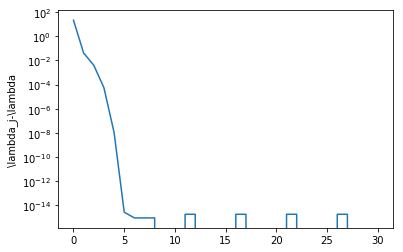

In [2]:
n = 100
k = 30
A = randn(n,n)
A = .5*(A+A.T)
q0 = rand(n)

lambda_iterates = rayleigh_quotient_iteration(A,q0,k,5)
plt.semilogy(np.abs(lambda_iterates-lambda_iterates[-1]))
plt.ylabel('\lambda_j-\lambda')

**Theorem**
Let $A\in\mathbb{R}^{n\times n}$ be symmetric. The Rayleigh quotient iteration converges for almost all start vectors. If it converges it converges cubically to an eigenpair of the matrix.